# World Models
**Jin Yeom**  
jin.yeom@hudl.com

In [18]:
import gym
from gym.spaces import Box
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import animation as anime
from IPython.display import HTML
import torch
from torch import nn
from torch.nn import functional as F

This notebook implements **[World Models](https://arxiv.org/abs/1803.10122)** (Ha and Schmidhuber, 2018). This work proposes a framework of model-based deep reinforcement learning. Two key differences in this work from more commonly seen deep RL algorithms (e.g., DQN, PPO, DDPG, etc.) are that 1) feature learning is separated from the controller, i.e., a world model agent isn't trained with a rather strange scheme of learning where it can only learn to see via reward signals, and 2) the agent's model is trained in an unsupervised fashion from its trajectory data; once trained, it can simulate the environment within a latent space (they describe this simulation as "dreaming").

The proposed agent consists of three components: the vision model ($V$) and the memory model ($M$), which together define the agent's world model, and a controller ($C$) for selecting actions. Ha and Schmidhuber chose to use a convolutional VAE for $V$ and a mixture density recurrent network for $M$, and a single layered network for $C$, which was evolved via CMA-ES. Note that their choice of architecture is more of a proof of concept and can be enhanced with more advanced algorithms.

## Environment

We'll start with something simple: **Atari 2600 Pong**.

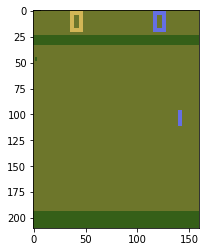

In [2]:
env = gym.make('PongNoFrameskip-v4')
obs = env.reset()
plt.imshow(obs)
plt.show()

In [3]:
class ProcessFrame(gym.ObservationWrapper):
    def __init__(self, env, size):
        super(ProcessFrame, self).__init__(env)
        self.size = size
        self.observation_space = Box(low=0, high=1, shape=(3, size, size), dtype=np.float32)

    def observation(self, obs):
        obs = Image.fromarray(obs[34:194, :160, :])  # crop the center square
        obs = np.array(obs.resize((self.size, self.size), resample=Image.BILINEAR))
        obs = obs.transpose(2, 0, 1).astype(np.float32) / 255.0
        return torch.from_numpy(obs)

In [4]:
class FrameSkip(gym.Wrapper):
    def __init__(self, env, frame_skip):
        super(FrameSkip, self).__init__(env)
        self._frame_skip = frame_skip

    def step(self, action):
        total_reward = 0.0
        for _ in range(self._frame_skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

    def reset(self):
        return self.env.reset()

In [5]:
def make_pong():
    env = gym.make('PongNoFrameskip-v4')
    env = ProcessFrame(env, 64)
    env = FrameSkip(env, 4)
    return env

In [6]:
env = make_pong()
fig = plt.figure()
ims = []
obs = env.reset()
for _ in range(64):
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)
    obs = obs.numpy().transpose(1, 2, 0)
    ims.append([plt.imshow(obs, animated=True)])
anim = anime.ArtistAnimation(fig, ims, interval=25, blit=True)
plt.close()
HTML(anim.to_html5_video())

## VAE (V) model

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        self.fc_mean = nn.Linear(1024, latent_dim)
        self.fc_logvar = nn.Linear(1024, latent_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x), inplace=True)
        x = F.relu(self.conv2(x), inplace=True)
        x = F.relu(self.conv3(x), inplace=True)
        x = F.relu(self.conv4(x), inplace=True)
        x = x.view(x.size(0), -1)
        return self.fc_mean(x), self.fc_logvar(x)

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_size):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 1024)
        self.deconv2 = nn.ConvTranspose2d(1024, 128, 5, stride=2)
        self.deconv3 = nn.ConvTranspose2d(128, 64, 5, stride=2)
        self.deconv4 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv5 = nn.ConvTranspose2d(32, 3, 5, stride=2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x), inplace=True)
        x = x.view(x.size(0), 1024, 1, 1)
        x = F.relu(self.deconv2(x), inplace=True)
        x = F.relu(self.deconv3(x), inplace=True)
        x = F.relu(self.deconv4(x), inplace=True)
        x = torch.sigmoid(self.deconv5(x))

In [11]:
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def encode(self, x):
        mu, logvar = self.encoder(x)
        if self.training:
            return self.reparameterize(mu, logvar)
        return mu
        
    def reparameterize(self, mu, logvar):
        sigma = torch.exp(0.5 * logvar)
        eps = torch.randn_like(mu)
        return eps.mul(sigma).add_(mu)
    
    def decode(self, z):
        return self.decoder(z)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        x_ = self.decoder(z)
        return mu, logvar, z, x_

## Controller (C) model

Once again, Ha and Schmidhuber used CMA-ES to evolve the controller, but that's not necessary. We'll use the single threaded **A2C** (Advantage Actor Critic) algorithm to train our controller.

In [19]:
class ActorCritic(nn.Module):
    def __init__(self, latent_dim, act_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Linear(latent_dim, act_dim)
        self.critic = nn.Linear(latent_dim, 1)
        
    def forward(self, x):
        return self.actor(x), self.critic(x)

## Data collection